## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tableone import TableOne
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, auc
import os
import pydata_google_auth

## Authenticate with GCP to access MIMIC

In [2]:
project_id = 'mimic-369422'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
    use_local_webserver=False
)

def run_query(query):
    return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      credentials=credentials,
      configuration={'query': {
          'useLegacySql': False
      }})

## Cohort Curation
#### Inclusion/Exclusion Criteria
1. Patients > 18
2. 1st ICU stay
3. Measurement of creatinine and urine ouput within 24 hours
4. aki stage 2 
5. not a CEER ICD 10-N18
6. No DNR

#### AKI Stage > 0

In [3]:
# Base the cohort off of patients with aki_stage > 0.
aki = run_query(
    """SELECT * FROM `physionet-data.mimiciv_derived.kdigo_stages` WHERE aki_stage <> 0"""
)

In [4]:
aki_pats = aki['subject_id'].unique()
len(aki_pats)

33146

#### First ICU Stay

In [5]:
# Get the ICU stays of the AKI patients and select the first one.
icustays = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_icu.icustays` WHERE subject_id IN {str(tuple(aki_pats))}"""
)
icustays.shape

(53573, 8)

In [6]:
# Returns the first ICU stay for each patient.
def get_first_icu_stay(df):
    min_stay = df.groupby(by='subject_id')['intime'].min().reset_index()
    result = df.merge(min_stay)
    return result

icu_first = get_first_icu_stay(icustays)
icu_first.shape

(33146, 8)

In [7]:
icu_first.nunique()

subject_id        33146
hadm_id           33146
stay_id           33146
first_careunit        9
last_careunit         9
intime            33146
outtime           33146
los               32077
dtype: int64

In [8]:
aki_icu = aki.merge(icu_first, on=['subject_id', 'hadm_id', 'stay_id'])
aki_icu.shape

(562149, 18)

aki_icu

In [9]:
aki_icu.nunique()

subject_id              29945
hadm_id                 29945
stay_id                 29945
charttime              447065
creat_low_past_7day       184
creat_low_past_48hr       191
creat                     220
aki_stage_creat             4
uo_rt_6hr               14461
uo_rt_12hr              17428
uo_rt_24hr              20280
aki_stage_uo                4
aki_stage                   3
first_careunit              9
last_careunit               9
intime                  29945
outtime                 29945
los                     29095
dtype: int64

#### Filter out patients with DNR request

In [10]:
aki_icu_enc = aki_icu['hadm_id'].unique()

In [11]:
# Get patients with DNR in the current cohort.
dnr = run_query(
    f"""SELECT hadm_id from `physionet-data.mimiciv_icu.chartevents` WHERE itemid=22378 or itemid=228687 
    AND hadm_id IN {str(tuple(aki_icu_enc))}"""
)
dnr.shape

(2413, 1)

In [12]:
aki_no_dnr = aki_icu[~aki_icu.isin(dnr['hadm_id'].values)]
aki_icu.shape

(562149, 18)

#### Creatinine and Urine Output within 24 hours of admission

In [13]:
aki_no_dnr_sid = aki_no_dnr['stay_id'].unique()

In [14]:
# Get creatinine and urine output values for the current cohort.
creatinine = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_derived.kdigo_creatinine` WHERE stay_id IN 
    {str(tuple(aki_no_dnr_sid))}"""
)
uo = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_derived.kdigo_uo` WHERE stay_id IN 
    {str(tuple(aki_no_dnr_sid))}
    """
)

In [15]:
# Find stay_ids that do not have a creatinine or uo value within 24 hours.
cohort_sid_intime = aki_no_dnr[['stay_id', 'intime']].drop_duplicates()
cohort_sid_intime.shape

(29945, 2)

In [16]:
cohort_sid_intime.nunique()

stay_id    29945
intime     29945
dtype: int64

In [17]:
# Merge with intime
creatinine_icu = cohort_sid_intime.merge(creatinine, on='stay_id', how='left')
uo_icu = cohort_sid_intime.merge(uo, on='stay_id', how='left')
print(creatinine_icu.nunique())
print(uo_icu.nunique())

stay_id                 29945
intime                  29945
hadm_id                 29945
charttime              294639
creat                     288
creat_low_past_48hr       252
creat_low_past_7day       245
dtype: int64
stay_id              29945
intime               29945
charttime           874955
weight                1708
urineoutput_6hr       3059
urineoutput_12hr      5104
urineoutput_24hr      8833
uo_rt_6hr            67925
uo_rt_12hr           61784
uo_rt_24hr           58085
uo_tm_6hr              301
uo_tm_12hr             661
uo_tm_24hr            1381
dtype: int64


In [18]:
# Calculate delta between intime and charttime in days.
creatinine_icu['delta_days'] = (creatinine_icu['charttime'] - creatinine_icu['intime']) / np.timedelta64(1, 'D')
uo_icu['delta_days'] = (uo_icu['charttime'] - uo_icu['intime']) / np.timedelta64(1, 'D')

In [19]:
creatinine_icu['delta_days'].describe()

count    296535.000000
mean          3.811834
std           7.433108
min          -6.999803
25%           0.111545
50%           1.500000
75%           5.127760
max         101.209722
Name: delta_days, dtype: float64

In [20]:
uo_icu['delta_days'].describe()

count    2.004746e+06
mean     5.443540e+00
std      7.443966e+00
min     -3.001042e+01
25%      1.103646e+00
50%      2.807240e+00
75%      6.825747e+00
max      1.015424e+02
Name: delta_days, dtype: float64

In [21]:
# Filter for measurements within 48 hours.
creatinine_icu_48 = creatinine_icu[(creatinine_icu['delta_days'] >= 0) & (creatinine_icu['delta_days'] <= 2)]
uo_icu_48 = uo_icu[(uo_icu['delta_days'] >= 0) & (uo_icu['delta_days'] <= 2)]

In [22]:
# Use set intersection to find ids that match by criterion. 
sids_48 = list(set(creatinine_icu_48['stay_id'].unique()).intersection(set(uo_icu_48['stay_id'].unique())))
len(sids_48)

29110

In [23]:
# Stays lost
len(aki_no_dnr_sid) - len(sids_48)

835

In [24]:
aki_creat_uo_48 = aki_no_dnr[aki_no_dnr['stay_id'].isin(sids_48)].reset_index(drop=True)
aki_creat_uo_48.shape

(555624, 18)

#### Patients greater than 18

In [25]:
aki_creat_uo_48_pats = aki_creat_uo_48['subject_id'].unique()

In [26]:
# Query patients in our current cohort under 18.
demo = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_hosp.patients` WHERE subject_id IN {str(tuple(aki_creat_uo_48_pats))} """
)

In [27]:
demo_18 = demo[demo['anchor_age'] < 18]

In [28]:
# No patients match so we can ignore this criteria.
demo_18.shape[0]

0

#### Filter to a single sample per patient.
Idea: Max AKI stage in the 1st 48 hours of the stay.
If duplicates, take the one closest to the intime.

In [29]:
# Calculate delta days.
aki_creat_uo_48['delta_hours_aki'] = (aki_creat_uo_48['charttime'] - aki_creat_uo_48['intime']) / np.timedelta64(1, 'h')

In [30]:
aki_creat_uo_48['delta_hours_aki'].describe()

count    555624.000000
mean        112.719909
std         170.999124
min        -159.816944
25%          23.550000
50%          51.166667
75%         127.562917
max        2284.089722
Name: delta_hours_aki, dtype: float64

In [31]:
cohort_48 = aki_creat_uo_48[(aki_creat_uo_48['delta_hours_aki'] >= 0) & (aki_creat_uo_48['delta_hours_aki'] <= 12)].reset_index(drop=True)

In [32]:
max_aki_48 = cohort_48.groupby(by='stay_id')['aki_stage'].max().reset_index().rename({'index' : 'stay_id'}, axis=1)

In [33]:
cohort_max_aki = aki_creat_uo_48.merge(max_aki_48)

In [34]:
# Select the min chart time.
min_chart = cohort_max_aki.groupby('stay_id')['charttime'].min().reset_index().rename({'index' : 'stay_id'}, axis=1)

In [35]:
cohort = cohort_max_aki.merge(min_chart)

In [36]:
# Drop NaN on hadm_id as NaN hadm_id's represent outpatients.
cohort = cohort.dropna(subset=['hadm_id'])
cohort.shape

(12688, 19)

## Add Covariates

#### Labs
- K+
- pH
- BUN
- HCO3

In [37]:
cohort_enc = cohort['hadm_id'].unique()
labs = run_query(
    f"""SELECT * FROM (select l.*, d.label from `physionet-data.mimiciv_hosp.labevents` AS l
        JOIN `physionet-data.mimiciv_hosp.d_labitems` d ON l.itemid = d.itemid WHERE 
        l.itemid IN (51006, 50822, 50971, 50810, 51221, 50912, 50862, 50820, 50882, 50803)
        ) 
        WHERE hadm_id IN {str(tuple(cohort_enc))}"""
)

In [38]:
labs.shape

(1289950, 16)

In [39]:
cohort_ts = cohort[['stay_id', 'hadm_id', 'intime', 'outtime']].drop_duplicates()

In [40]:
# Convert dates to datetime.
cohort_ts['intime'] = pd.to_datetime(cohort_ts['intime'])
cohort_ts['outtime'] = pd.to_datetime(cohort_ts['outtime'])
labs['charttime'] = pd.to_datetime(labs['charttime'])

In [41]:
# Filter labs to only keep those whose charttime is between an admissions intime and outtime. 
labs_merged = labs.merge(cohort_ts, on='hadm_id')
labs_filt = labs_merged[(labs_merged['charttime'] >= labs_merged['intime']) & (labs_merged['charttime'] <= labs_merged['outtime'])]
labs_filt.shape

(710056, 19)

In [42]:
# Pivot table to get the min and max values of labs. 
lab_description = pd.pivot_table(labs, values=['valuenum'], index=['hadm_id'], columns=['label'], aggfunc=[np.nanmin, np.nanmax])
lab_description = lab_description.reset_index()
# Restore correct columns.
cols = ["_".join(x) for x in list(lab_description)]
cols[0] = 'hadm_id'
lab_description.columns = cols

In [43]:
lab_description.head()

,hadm_id,nanmin_valuenum_Albumin,nanmin_valuenum_Bicarbonate,"nanmin_valuenum_Calculated Bicarbonate, Whole Blood",nanmin_valuenum_Creatinine,nanmin_valuenum_Hematocrit,"nanmin_valuenum_Hematocrit, Calculated",nanmin_valuenum_Potassium,"nanmin_valuenum_Potassium, Whole Blood",nanmin_valuenum_Urea Nitrogen,...,nanmax_valuenum_Albumin,nanmax_valuenum_Bicarbonate,"nanmax_valuenum_Calculated Bicarbonate, Whole Blood",nanmax_valuenum_Creatinine,nanmax_valuenum_Hematocrit,"nanmax_valuenum_Hematocrit, Calculated",nanmax_valuenum_Potassium,"nanmax_valuenum_Potassium, Whole Blood",nanmax_valuenum_Urea Nitrogen,nanmax_valuenum_pH
0,20000094,3.1,19.0,NaN,3.8,40.1,NaN,4.3,NaN,99.0,...,3.6,28.0,NaN,3.9,42.1,NaN,4.6,NaN,99.0,7.41
1,20001305,2.6,21.0,NaN,0.8,31.4,NaN,4.1,NaN,47.0,...,2.6,25.0,NaN,1.2,34.5,NaN,4.7,NaN,59.0,7.46
2,20001361,3.0,20.0,NaN,1.6,30.6,NaN,3.4,NaN,24.0,...,3.2,26.0,NaN,4.2,37.2,NaN,5.8,NaN,49.0,7.48
3,20001729,3.5,17.0,NaN,1.1,24.1,26.0,3.7,3.3,10.0,...,3.5,33.0,NaN,3.7,38.3,28.0,5.7,4.5,58.0,7.48
4,20001770,2.0,15.0,NaN,0.7,19.9,NaN,3.4,3.4,9.0,...,3.0,22.0,NaN,1.7,28.4,NaN,5.2,3.4,23.0,7.26


In [44]:
cohort_icu_labs = cohort.merge(lab_description, on='hadm_id')

In [45]:
cohort_icu_labs.shape

(12683, 39)

#### SOFA Score
Select SOFA closest to icu admission.

In [46]:
cohort_sid = cohort_icu_labs['stay_id'].unique()

In [47]:
# Query SOFA scores for the selected stays.
sofa = run_query(
    f"""SELECT stay_id, hr, starttime, endtime, sofa_24hours
    FROM `physionet-data.mimiciv_derived.sofa` WHERE stay_id IN {str(tuple(cohort_sid))}"""
)

In [48]:
sofa.shape

(1377183, 5)

In [49]:
sofa_48 = sofa[sofa['hr'] <= 48]

In [50]:
sofa_48_min = dict(sofa_48.groupby(by='stay_id')['hr'].min())

In [51]:
sofa['min_hour'] = sofa['stay_id'].map(sofa_48_min)

In [52]:
sofa = sofa[sofa['min_hour'] == sofa['hr']]
sofa.shape

(12683, 6)

In [53]:
cohort_sofa = cohort_icu_labs.merge(sofa, on='stay_id', how='left')
cohort_sofa.shape

(12683, 44)

#### Antibiotics

In [54]:
antib = run_query(
    f"""
    SELECT a.stay_id, a.starttime, a.route, a.antibiotic FROM `physionet-data.mimiciv_derived.antibiotic` AS a
    where (a.antibiotic like "Vancomycin" or a.antibiotic like 
    "Gentamicin" or a.antibiotic like "Vancocin" 
    or a.antibiotic like "Gentamicin (Bulk)" or a.antibiotic like 'NEO*IV*Gentamicin' 
    or a.antibiotic like 'NEO*IV*Vancomycin' or a.antibiotic like 'Gentamicin Sulfate') AND
    a.stay_id IN {str(tuple(cohort_sid))}
    """
)
antib.shape

(18244, 4)

In [55]:
antib['antibiotic'] = 1

In [56]:
cohort_stay_intime = cohort_sofa[['stay_id', 'intime']].drop_duplicates()
antib['starttime'] = pd.to_datetime(antib['starttime'])
antib = antib.dropna(subset='stay_id')
antib_intime_stayid = cohort_stay_intime.merge(antib, on='stay_id')
antib_intime_stayid['delta_days'] = (antib_intime_stayid['starttime'] - antib_intime_stayid['intime']) / np.timedelta64(1, 'D')
antib_intime_stayid_48 = antib_intime_stayid[antib_intime_stayid['delta_days'] <= 2]
antib_intime_stayid_48 = antib_intime_stayid_48.drop_duplicates(subset=['stay_id'])
antib_intime_stayid_48 = antib_intime_stayid_48[['stay_id', 'antibiotic']]
cohort_antib = cohort_sofa.merge(antib_intime_stayid_48, on='stay_id', how='left')
cohort_antib['antibiotic'].fillna(0, inplace=True)
cohort_antib.shape

(12683, 45)

In [57]:
cohort_antib['antibiotic'].value_counts()

0.0    7416
1.0    5267
Name: antibiotic, dtype: int64

#### Sepsis

In [58]:
sepsis = run_query(
    f"""
    SELECT stay_id, sepsis3 FROM `physionet-data.mimiciv_derived.sepsis3` WHERE
    stay_id IN {str(tuple(cohort_sid))}
    """
)
sepsis.shape

(7643, 2)

In [59]:
sepsis.drop_duplicates(inplace=True)
sepsis.shape

(7643, 2)

In [60]:
cohort_sepsis = cohort_antib.merge(sepsis, on='stay_id', how='left')
cohort_sepsis['sepsis3'].value_counts(dropna=False)
cohort_sepsis['sepsis3'].fillna(False, inplace=True)
cohort_sepsis.shape

(12683, 46)

#### Vitals
- Heart Rate
- MBP
- MBP_NI
- Resp Rate
- SPo2

In [61]:
# Query requested vitals attributes for the cohort.
cohort_sids = cohort_sepsis['stay_id'].unique()
vitals = run_query(
    f"""
    SELECT stay_id, charttime, heart_rate, mbp, mbp_ni, resp_rate, spo2
    FROM `physionet-data.mimiciv_derived.vitalsign` WHERE stay_id IN 
    {str(tuple(cohort_sids))}
    """
)

In [62]:
# Get min and max vitals.
agg_cols = ['heart_rate', 'mbp', 'mbp_ni', 'resp_rate', 'spo2']
vitals_min = vitals.groupby('stay_id')[agg_cols].min().reset_index()
vitals_min.rename(dict(zip(agg_cols, ['min_' + x for x in agg_cols])), axis=1, inplace=True)
vitals_max = vitals.groupby('stay_id')[agg_cols].max().reset_index()
vitals_max.rename(dict(zip(agg_cols, ['max_' + x for x in agg_cols])), axis=1, inplace=True)

In [63]:
cohort_vitals = cohort_sepsis.merge(vitals_min, on='stay_id', how='left')
cohort_vitals = cohort_vitals.merge(vitals_max, on='stay_id', how='left')

In [64]:
cohort_vitals.shape

(12683, 56)

#### Comorbdities
- CKD
- Hypotension
- Heart Failure
- Diabetes

In [65]:
# Query all icd codes for our cohort.
cohort_enc = cohort_vitals['hadm_id'].unique()
icdcodes = run_query(
    f"""
    SELECT * FROM `physionet-data.mimiciv_hosp.diagnoses_icd` WHERE 
    hadm_id IN {str(tuple(cohort_enc))}
    """
)
icdcodes.shape

(249363, 5)

In [66]:
"""
Functions for calculating comorbidities based on ICD9/10 codes.
"""
def is_DM(row):
    
    if row.icd_version== 9:
        if row.icd_code == 7751:
            return 1 
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 25000 and pd.to_numeric(row.icd_code, errors= "coerce") <= 25033:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64800 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64804:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 24900 and pd.to_numeric(row.icd_code, errors= "coerce") <= 24931:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 25040 and pd.to_numeric(row.icd_code, errors= "coerce") <= 25093:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 24940 and pd.to_numeric(row.icd_code, errors= "coerce") <= 24991:
            return 1
        else:
            return 0 
        
    if row.icd_version== 10:       
        if row.icd_code.startswith('E08') or row.icd_code.startswith('E09') or row.icd_code.startswith('E10') or row.icd_code.startswith('E11') or row.icd_code.startswith('E12') or row.icd_code.startswith('E13'):
            return 1      
        else:
            return 0

def is_HF(row): #heart failure
    if row.icd_version== 9:
        if pd.to_numeric(row.icd_code, errors= "coerce") == 4280 or pd.to_numeric(row.icd_code, errors= "coerce") == 4281 or pd.to_numeric(row.icd_code, errors= "coerce") == 4289 or pd.to_numeric(row.icd_code, errors= "coerce")==39891:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 42820 and pd.to_numeric(row.icd_code, errors= "coerce") <= 42823:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 42830 and pd.to_numeric(row.icd_code, errors= "coerce") <= 42832:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 42840 and pd.to_numeric(row.icd_code, errors= "coerce") <= 42843:
            return 1
        else:
            return 0 
        
    if row.icd_version== 10:
        if row.icd_code.startswith('I13') or row.icd_code.startswith('I11') or row.icd_code.startswith('I25') or row.icd_code.startswith('I46') or row.icd_code.startswith('I50') or row.icd_code.startswith('I42') or row.icd_code.startswith('I43')  or row.icd_code.startswith('I44'):
            return 1      
        else:
            return 0

# Hypertension -icd 9 and 10 
def is_Hypert(row): 
    
    l=[4010,4011,4019,4372,40200,40210,40290,40509,40519,40201,40211,40291,40310,40300,40390,40501,40511,
       40591,40301,40311,40391,40400,40410,40490,40401,40411,40491,40402,40412,40492,40403,40413,40493]
    
    if row.icd_version== 9:

        if pd.to_numeric(row.icd_code, errors= "coerce") in l:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64200 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64204:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64220 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64224:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64210 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64214:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64270 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64274:
            return 1   
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64290 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64294:
            return 1   
        else:
            return 0 
        
    if row.icd_version== 10:
        if row.icd_code.startswith('I10') or row.icd_code.startswith('I15') or row.icd_code.startswith('I16'):
            return 1      
        else:
            return 0

def is_CKD(row):
    if row.icd_version== 9:
        
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 5851 and pd.to_numeric(row.icd_code, errors= "coerce") <= 5856:
            return 1     
        if pd.to_numeric(row.icd_code, errors= "coerce") == 5859:
            return 1   
        else:
            return 0 
        
    if row.icd_version== 10:
        if row.icd_code.startswith('I12') or row.icd_code.startswith('I12') or row.icd_code.startswith('N01') or row.icd_code.startswith('N02') or row.icd_code.startswith('N03') or row.icd_code.startswith('N04') or row.icd_code.startswith('N05') or row.icd_code.startswith('N06') or row.icd_code.startswith('N07') or row.icd_code.startswith('N08') or row.icd_code.startswith('N11') or row.icd_code.startswith('N13')     or row.icd_code.startswith('N14') or row.icd_code.startswith('N15') or row.icd_code.startswith('N18') or row.icd_code.startswith('N19') or row.icd_code.startswith('N25') or row.icd_code.startswith('N26') or row.icd_code.startswith('N27') or row.icd_code.startswith('N28') or row.icd_code.startswith('N29'):
            return 1      
        else:
            return 0  

In [67]:
# Calculate binary labels on icd codes.
icdcodes['dm'] = icdcodes.apply(is_DM, axis=1)
icdcodes['heartfailure'] = icdcodes.apply(is_HF, axis=1)
icdcodes['hypertension'] = icdcodes.apply(is_Hypert, axis=1)
icdcodes['ckd'] = icdcodes.apply(is_CKD, axis=1)

In [68]:
# Get one value for every stay ID.
ckd   = icdcodes.groupby('hadm_id')['ckd'].max().reset_index()
dm    = icdcodes.groupby('hadm_id')['dm'].max().reset_index()
hyper = icdcodes.groupby('hadm_id')['hypertension'].max().reset_index()
hf    = icdcodes.groupby('hadm_id')['heartfailure'].max().reset_index()

In [69]:
# Construct comorbdities dataframe.
comorbidities = ckd.merge(dm, on='hadm_id', how='left')
comorbidities = comorbidities.merge(hyper, on='hadm_id', how='left')
comorbidities = comorbidities.merge(hf, on='hadm_id', how='left')
comorbidities = comorbidities.fillna(0)

In [70]:
cohort_covariates = cohort_vitals.merge(comorbidities, on='hadm_id', how='left')

## Merge with CRRT Labels
Criteria - Only consider patients that recieved CRRT after the first 12 hours and before the first 5 days of their ICU stay 

In [71]:
cohort_sid = cohort_covariates['stay_id'].unique()

In [72]:
crrt = run_query(
    f"""
    SELECT * FROM `physionet-data.mimiciv_derived.crrt` 
    WHERE stay_id IN {str(tuple(cohort_sid))}
    """
)
crrt.shape

(117037, 24)

In [73]:
cohort_ts = cohort_covariates[['stay_id', 'intime']].drop_duplicates()

In [74]:
crrt['charttime'] = pd.to_datetime(crrt['charttime'])
crrt_icu = crrt.merge(cohort_ts, on='stay_id')
crrt_icu['time_delta'] = (crrt_icu['charttime'] - crrt_icu['intime']) / np.timedelta64(1, 'h')
crrt_icu = crrt_icu[crrt_icu['charttime'] > crrt_icu['intime']].reset_index(drop=True)
min_crrt = crrt_icu.groupby('stay_id')['charttime'].min().reset_index()
crrt_min = crrt_icu.merge(min_crrt)
crrt_min.shape

(964, 26)

Text(0.5, 1.0, 'CRRT Incidence Distribution')

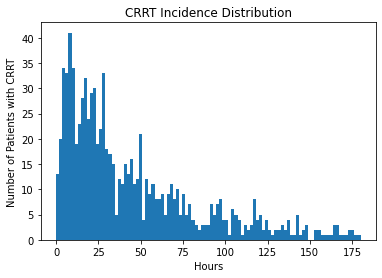

In [75]:
b= np.linspace(0, 180, 100)
plt.hist(crrt_min['time_delta'], bins=b)
plt.xlabel('Hours')
plt.ylabel('Number of Patients with CRRT')
plt.title('CRRT Incidence Distribution')

In [76]:
# Keep patients [0.5 days to 5 day window]
crrt_filt = crrt_min[(crrt_min['time_delta'] >= 12) &  (crrt_min['time_delta'] <= 120)].reset_index(drop=True)
crrt_filt.shape

(631, 26)

In [77]:
# Merge with CRRT Labels
crrt_filt['crrt'] = 1
crrt_filt = crrt_filt[['stay_id', 'crrt', 'time_delta']].drop_duplicates()
cohort_final = cohort_covariates.merge(crrt_filt, on='stay_id', how='left')
cohort_final['crrt'].fillna(0, inplace=True)

#### Merge with Demographics

In [78]:
cohort_pats = cohort_final['subject_id'].unique()
demo = run_query(
    f"""
        SELECT * from `physionet-data.mimiciv_hosp.patients` 
        WHERE subject_id IN {str(tuple(cohort_pats))}
    """
)
# Some demographic data is stored in admissions.
admissions = run_query(
    f"""
        SELECT * from `physionet-data.mimiciv_hosp.admissions` 
        WHERE subject_id IN {str(tuple(cohort_pats))}
    """
)

In [79]:
cohort_final = cohort_final.merge(demo, on='subject_id')
cohort_final = cohort_final.merge(admissions, on=['subject_id', 'hadm_id'])

In [80]:
# Cluster Races
targets = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER']
for group in cohort_final['race'].unique():
    if 'WHITE' in group:
        cohort_final['race'] = cohort_final['race'].replace(group, 'WHITE')
    elif 'BLACK' in group:
        cohort_final['race'] = cohort_final['race'].replace(group, 'BLACK')
    elif 'ASIAN' in group:
        cohort_final['race'] = cohort_final['race'].replace(group, 'ASIAN')
    elif 'HISPANIC' in group:
        cohort_final['race'] = cohort_final['race'].replace(group, 'HISPANIC')
    elif 'UNKNOWN' in group:
        continue
    else:
        cohort_final['race'] = cohort_final['race'].replace(group, 'OTHER')
        

In [81]:
cohort_final['race'].value_counts()

WHITE       8533
UNKNOWN     1593
BLACK       1157
OTHER        767
HISPANIC     364
ASIAN        269
Name: race, dtype: int64

In [82]:
cohort_final.shape

(12683, 80)

In [83]:
cohort_final.to_csv('final_crrt_cohort.csv', index=False)

## Table 1

In [84]:
columns_all = ['first_careunit', 'creat_low_past_48hr', 'aki_stage', 'race','min_heart_rate',
 'min_mbp',
 'min_mbp_ni',
 'min_resp_rate',
 'min_spo2',
 'max_heart_rate',
 'max_mbp',
 'max_mbp_ni',
 'max_resp_rate',
 'max_spo2',
 'ckd',
 'dm',
 'hypertension',
 'heartfailure',
'nanmin_valuenum_Albumin',
 'nanmin_valuenum_Bicarbonate',
 'nanmin_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmin_valuenum_Creatinine',
 'nanmin_valuenum_Hematocrit',
 'nanmin_valuenum_Hematocrit, Calculated',
 'nanmin_valuenum_Potassium',
 'nanmin_valuenum_Potassium, Whole Blood',
 'nanmin_valuenum_Urea Nitrogen',
 'nanmin_valuenum_pH',
 'nanmax_valuenum_Albumin',
 'nanmax_valuenum_Bicarbonate',
 'nanmax_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmax_valuenum_Creatinine',
 'nanmax_valuenum_Hematocrit',
 'nanmax_valuenum_Hematocrit, Calculated',
 'nanmax_valuenum_Potassium',
 'nanmax_valuenum_Potassium, Whole Blood',
 'nanmax_valuenum_Urea Nitrogen',
 'nanmax_valuenum_pH',
 'sepsis3',
 'sofa_24hours',
 'antibiotic',
 'gender']

numerical_all =[
    'creat_low_past_48hr',
    'min_heart_rate',
    'min_mbp',
 'min_mbp_ni',
 'min_resp_rate',
 'min_spo2',
 'max_heart_rate',
 'max_mbp',
 'max_mbp_ni',
 'max_resp_rate',
 'max_spo2','nanmin_valuenum_Albumin',
 'nanmin_valuenum_Bicarbonate',
 'nanmin_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmin_valuenum_Creatinine',
 'nanmin_valuenum_Hematocrit',
 'nanmin_valuenum_Hematocrit, Calculated',
 'nanmin_valuenum_Potassium',
 'nanmin_valuenum_Potassium, Whole Blood',
 'nanmin_valuenum_Urea Nitrogen',
 'nanmin_valuenum_pH',
 'nanmax_valuenum_Albumin',
 'nanmax_valuenum_Bicarbonate',
 'nanmax_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmax_valuenum_Creatinine',
 'nanmax_valuenum_Hematocrit',
 'nanmax_valuenum_Hematocrit, Calculated',
 'nanmax_valuenum_Potassium',
 'nanmax_valuenum_Potassium, Whole Blood',
 'nanmax_valuenum_Urea Nitrogen',
 'nanmax_valuenum_pH',
        'sofa_24hours',]

for col in numerical_all:
    cohort_final[col] = cohort_final[col].astype(np.float64)

categorical_all = [x for x in columns_all if x not in numerical_all]

tab = TableOne(cohort_final, columns=columns_all,categorical=categorical_all, groupby='crrt')

/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq

In [85]:
# Display entire dataframe.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.precision', 5)

In [86]:
tab

Grouped by crrt                                          
                                                                                                                Missing         Overall       0.0           1.0          
n                                                                                                                                       12683         12052           631
first_careunit, n (%)                                          Cardiac Vascular Intensive Care Unit (CVICU)          0            1845 (14.5)   1752 (14.5)     93 (14.7)
                                                               Coronary Care Unit (CCU)                                           1474 (11.6)   1393 (11.6)     81 (12.8)
                                                               Medical Intensive Care Unit (MICU)                                 2820 (22.2)   2612 (21.7)    208 (33.0)
                                                               Medical/Surgical Intensive Care Unit (MICU/SICU)                   2257 (17.8)   2161 (17.9)     96 (15.2)
                                                               Neuro Intermediate                                                    48 (0.4)      48 (0.4)              
                                                               Neuro Stepdown                                                        34 (0.3)      34 (0.3)              
                                                               Neuro Surgical Intensive Care Unit (Neuro SICU)                      256 (2.0)     250 (2.1)       6 (1.0)
                                                               Surgical Intensive Care Unit (SICU)                                1988 (15.7)   1898 (15.7)     90 (14.3)
                                                               Trauma SICU (TSICU)                                                1961 (15.5)   1904 (15.8)      57 (9.0)
creat_low_past_48hr, mean (SD)                                                                                    9466              1.9 (2.2)     1.8 (2.1)     2.9 (2.2)
aki_stage, n (%)                                               1                                                     0            5685 (44.8)   5526 (45.9)    159 (25.2)
                                                               2                                                                  6079 (47.9)   5745 (47.7)    334 (52.9)
                                                               3                                                                    919 (7.2)     781 (6.5)    138 (21.9)
race, n (%)                                                    ASIAN                                                 0              269 (2.1)     258 (2.1)      11 (1.7)
                                                               BLACK                                                               1157 (9.1)    1096 (9.1)      61 (9.7)
                                                               HISPANIC                                                             364 (2.9)     340 (2.8)      24 (3.8)
                                                               OTHER                                                                767 (6.0)     725 (6.0)      42 (6.7)
                                                               UNKNOWN                                                            1593 (12.6)   1473 (12.2)    120 (19.0)
                                                               WHITE                                                              8533 (67.3)   8160 (67.7)    373 (59.1)
min_heart_rate, mean (SD)                                                                                            1            64.9 (15.3)   65.2 (15.3)   60.0 (16.0)
min_mbp, mean (SD)                                                                                                   2            50.7 (15.7)   51.3 (15.3)   37.8 (16.5)
min_mbp_ni, mean (SD)           

In [87]:
tab.to_csv('tableone.csv')

## Model Training

#### Baseline model
No strategy to handle class imbalance

In [88]:
data = cohort_final.copy()

In [89]:
# Select variables for the model.
columns = [
 'min_spo2',
 'max_spo2',
'nanmin_valuenum_Albumin',
 'nanmin_valuenum_Creatinine',
 'nanmin_valuenum_Hematocrit',
 'nanmin_valuenum_Potassium',
 'nanmin_valuenum_Potassium, Whole Blood',
 'nanmin_valuenum_Urea Nitrogen',
 'nanmin_valuenum_pH',
 'nanmax_valuenum_Albumin',
 'nanmax_valuenum_Creatinine',
 'nanmax_valuenum_Hematocrit',
 'nanmax_valuenum_Hematocrit, Calculated',
 'nanmax_valuenum_Potassium',
 'nanmax_valuenum_Potassium, Whole Blood',
 'nanmax_valuenum_Urea Nitrogen',
 'nanmax_valuenum_pH',
'ckd' ,                                                     
  'dm',                                                    
 'hypertension',                                     
 'heartfailure',
]
categorical = ['ckd' ,                                                     
  'dm',                                                    
 'hypertension',                                     
 'heartfailure'
]

numerical = [x for x in columns if x not in categorical]

In [90]:
def train_predict_lr(data, columns, numerical, categorical):
    sc = StandardScaler()
    oh = OneHotEncoder()
    
    train, test = train_test_split(data, test_size=0.3, random_state=2022, stratify=data['crrt'].ravel())
    
    X_train = train[columns].fillna(-1)
    X_test = test[columns].fillna(-1)
    y_train = train['crrt'].ravel()
    y_test = test['crrt'].ravel()
    
    
    X_num_train = sc.fit_transform(X_train[numerical])
    X_num_test = sc.transform(X_test[numerical])
    X_cat_train = X_train[categorical]
    X_cat_test = X_test[categorical]
    
    X_train_proc = np.hstack((X_num_train, X_cat_train))
    X_test_proc = np.hstack((X_num_test, X_cat_test))
    
    clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=2022)
    clf.fit(X_train_proc, y_train)
    print(dict(zip(columns, clf.coef_.ravel())))
    yHat = clf.predict_proba(X_test_proc)
    return test, y_test, yHat

In [91]:
_, y_test, yHat = train_predict_lr(data, columns, numerical, categorical)

{'min_spo2': -0.3965310930118912, 'max_spo2': 0.29339726983322406, 'nanmin_valuenum_Albumin': -0.5472233918209383, 'nanmin_valuenum_Creatinine': -0.09252512763967964, 'nanmin_valuenum_Hematocrit': -0.18041551538207612, 'nanmin_valuenum_Potassium': 0.23796372729321372, 'nanmin_valuenum_Potassium, Whole Blood': 0.16104691073596386, 'nanmin_valuenum_Urea Nitrogen': -0.46500890745743034, 'nanmin_valuenum_pH': -7.928814807353349, 'nanmax_valuenum_Albumin': 0.7203674664105558, 'nanmax_valuenum_Creatinine': 1.1400802690515417, 'nanmax_valuenum_Hematocrit': -0.057695580426575875, 'nanmax_valuenum_Hematocrit, Calculated': -0.013347800605931583, 'nanmax_valuenum_Potassium': 0.23076847972683737, 'nanmax_valuenum_Potassium, Whole Blood': 0.0422951376035275, 'nanmax_valuenum_Urea Nitrogen': 0.4023038022455908, 'nanmax_valuenum_pH': 8.517244742141342, 'ckd': 0.1989318617838049, 'dm': 0.09436731584963134, 'hypertension': -0.1070495906070621, 'heartfailure': 0.09325854823284759}


(array([1657.,  728.,  333.,  225.,  161.,  115.,  117.,  118.,  137.,
         214.]),
 array([8.94908723e-04, 1.00805326e-01, 2.00715743e-01, 3.00626160e-01,
        4.00536577e-01, 5.00446994e-01, 6.00357411e-01, 7.00267828e-01,
        8.00178245e-01, 9.00088662e-01, 9.99999079e-01]),
 <BarContainer object of 10 artists>)

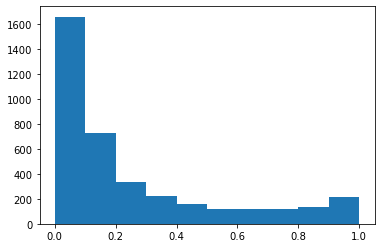

In [92]:
plt.hist(yHat[:, 1])

In [93]:
ypred = (yHat[:, 1] >= 0.5)

In [94]:
fpr, tpr, _ = roc_curve(y_test, yHat[:,1])
rocauc = auc(fpr, tpr)

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      3616
         1.0       0.24      0.88      0.37       189

    accuracy                           0.85      3805
   macro avg       0.61      0.87      0.64      3805
weighted avg       0.96      0.85      0.89      3805



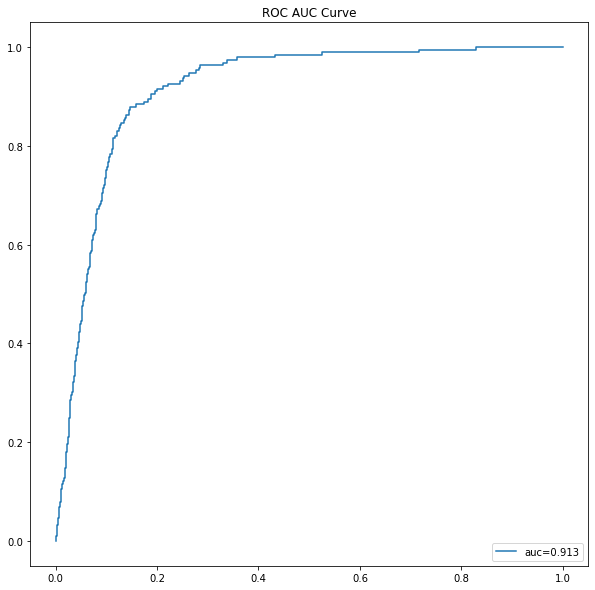

In [95]:
plt.figure(figsize=(10, 10))
plt.title('ROC AUC Curve')
plt.plot(fpr, tpr, label=f'auc={round(rocauc, 3)}')
plt.legend(loc=4)

print(classification_report(y_test, ypred))

#### Majority Class Undersampling

In [96]:
data.shape

(12683, 80)

In [97]:
data['crrt'].value_counts(dropna=False)

0.0    12052
1.0      631
Name: crrt, dtype: int64

In [98]:
nocrrt, crrt = data['crrt'].value_counts()

In [99]:
nocrrt_df = data[data['crrt'] == 0].reset_index(drop=True)
nocrrt_df_under = nocrrt_df.sample(n=crrt, random_state=2022)

In [100]:
crrt_df = data[data['crrt'] == 1].reset_index(drop=True)

In [101]:
under_sampled = pd.concat([crrt_df, nocrrt_df_under], axis=0).sample(frac=1)

In [102]:
under_sampled['crrt'].value_counts()

0.0    631
1.0    631
Name: crrt, dtype: int64

In [103]:
test_under, under_ytest, under_yHat = train_predict_lr(under_sampled, columns, numerical, categorical)

{'min_spo2': -0.4852047853834246, 'max_spo2': 0.1275742150991979, 'nanmin_valuenum_Albumin': -0.20834890296303632, 'nanmin_valuenum_Creatinine': -0.27070791975477343, 'nanmin_valuenum_Hematocrit': -0.029813067747945267, 'nanmin_valuenum_Potassium': 0.12755607056666335, 'nanmin_valuenum_Potassium, Whole Blood': -0.6214020245588742, 'nanmin_valuenum_Urea Nitrogen': -0.2587734578499637, 'nanmin_valuenum_pH': -1.5201620121199284, 'nanmax_valuenum_Albumin': 0.31521468315400913, 'nanmax_valuenum_Creatinine': 1.524030435521787, 'nanmax_valuenum_Hematocrit': -0.17537377615311694, 'nanmax_valuenum_Hematocrit, Calculated': -0.07035163086763366, 'nanmax_valuenum_Potassium': 0.2538660824177118, 'nanmax_valuenum_Potassium, Whole Blood': 0.9666497534717178, 'nanmax_valuenum_Urea Nitrogen': 0.4160818026598768, 'nanmax_valuenum_pH': 2.0042514398732734, 'ckd': 0.08715115694850646, 'dm': 0.05534529373130768, 'hypertension': 0.06822913953444272, 'heartfailure': 0.02438402149205089}


(array([77., 47., 32., 17., 16., 26., 26., 33., 40., 65.]),
 array([0.00605928, 0.10545334, 0.2048474 , 0.30424146, 0.40363552,
        0.50302958, 0.60242364, 0.7018177 , 0.80121176, 0.90060582,
        0.99999988]),
 <BarContainer object of 10 artists>)

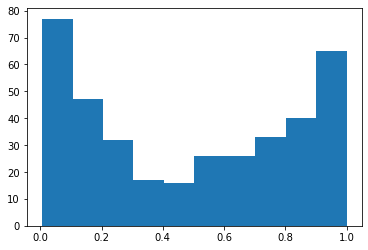

In [104]:
plt.hist(under_yHat[:, 1])

In [105]:
fpr, tpr, _ = roc_curve(under_ytest, under_yHat[:,1])
rocauc = auc(fpr, tpr)

In [106]:
ypred_under = (under_yHat[:, 1] >= 0.5)

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       189
         1.0       0.82      0.83      0.82       190

    accuracy                           0.82       379
   macro avg       0.82      0.82      0.82       379
weighted avg       0.82      0.82      0.82       379



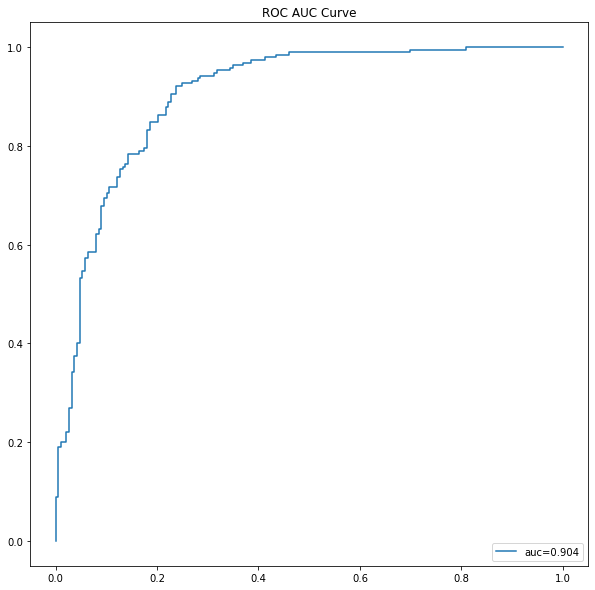

In [107]:
plt.figure(figsize=(10, 10))
plt.title('ROC AUC Curve')
plt.plot(fpr, tpr, label=f'auc={round(rocauc, 3)}')
plt.legend(loc=4)

print(classification_report(under_ytest, ypred_under))

In [108]:
# Stratify by AKI stage.
test_under['prediction'] = under_yHat[:, 1]

/tmp/ipykernel_27248/532204791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['prediction'] = under_yHat[:, 1]


Text(0.5, 1.0, 'Performance by AKI')

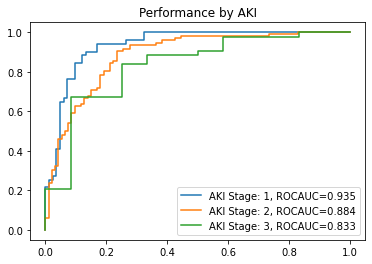

In [109]:
# Plot ROC curves for AKI stratified by stage.
for aki in test_under['aki_stage'].unique():
    tmp = test_under[test_under['aki_stage'] == aki]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    fpr, tpr, _ = roc_curve(ytest, ypred)
    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AKI Stage: {aki}, ROCAUC={round(rocauc, 3)}')
plt.legend(loc=4)
plt.title("Performance by AKI")

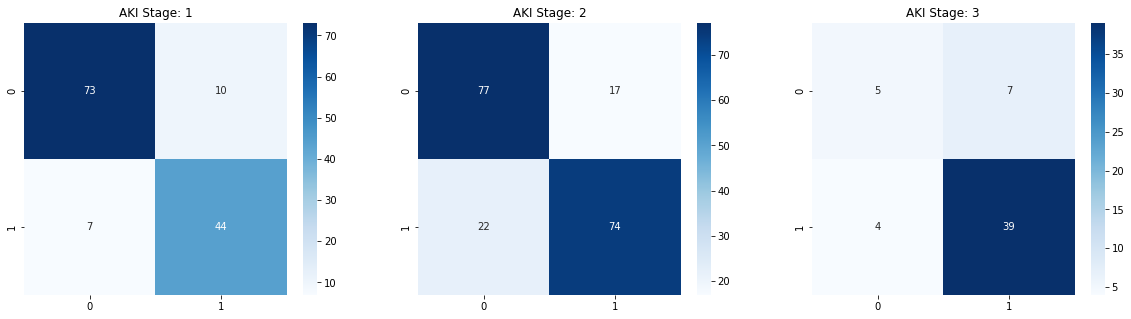

In [110]:
# Confusion matrices.
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, aki in enumerate(test_under['aki_stage'].unique()):
    tmp = test_under[test_under['aki_stage'] == aki]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    ypred = (ypred >= 0.5)
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(cm, annot=True, ax=ax[i], cmap='Blues')
    ax[i].set_title(f'AKI Stage: {aki}')

In [111]:
test_under['time_delta'].describe()

count    190.00000
mean      45.17130
std       28.30426
min       12.80000
25%       22.24896
50%       33.69736
75%       61.41250
max      119.27611
Name: time_delta, dtype: float64

Text(0.5, 1.0, 'Performance by Time')

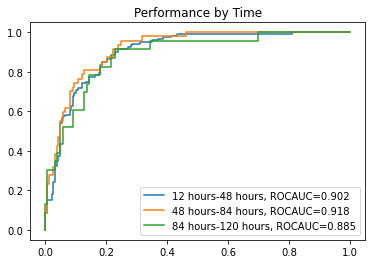

In [112]:
# Plot ROC curves for AKI stratified by stage.
step = 36
for i in range(12, 120, step):
    lower_bound = i
    upper_bound = i + step
    tmp = test_under[((test_under['time_delta'] >= lower_bound) & (test_under['time_delta'] <= upper_bound)) | (test_under['crrt'] == 0)]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    fpr, tpr, _ = roc_curve(ytest, ypred)

    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{i} hours-{i+step} hours, ROCAUC={round(rocauc, 3)}')
plt.legend(loc=4)
plt.title("Performance by Time")

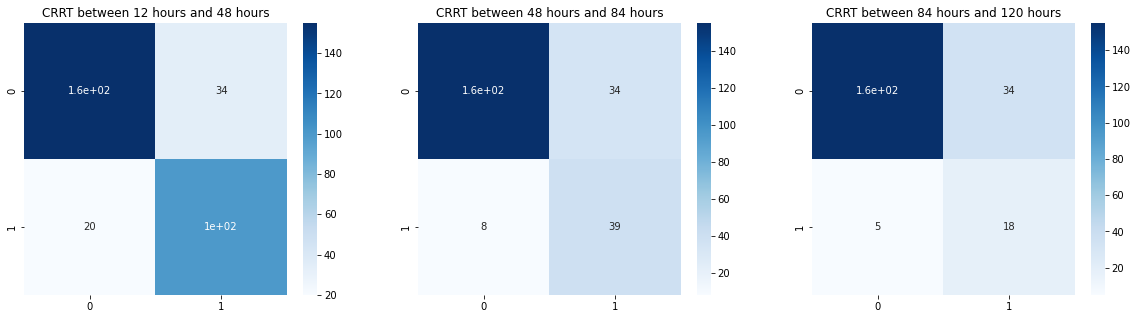

In [113]:
# Confusion matrices.
step = 36
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
counter = 0
for i in range(12, 120, step):
    lower_bound = i
    upper_bound = i + step
    tmp = test_under[((test_under['time_delta'] >= lower_bound) & (test_under['time_delta'] <= upper_bound)) | (test_under['crrt'] == 0)]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    ypred = (ypred >= 0.5)
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(cm, annot=True, ax=ax[counter], cmap='Blues')
    ax[counter].set_title(f'CRRT between {lower_bound} hours and {upper_bound} hours')
    counter+=1